In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
threshold_for_results = 0.5

# RAM workable at 5% rescaled
#rescaled_size = (54,96)

# Grayscale has 1 dim (Can drop it)
# Width, Height
#input_shape = (200, 100)
#flatten_shape = (20000)

# RGB has 3 dims
input_shape = (None, 100, 200, 3)
flatten_shape = (None, 20000, 3)
flatten_value = 20000

print("Shape Ready")

Shape Ready


In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020

from numpy.random import seed
seed(seed_value)

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
#tf.random.set_random_seed(seed_value)

print(tf.__version__)
print("Seed values re-set to 2019.")

2.2.0-rc2
Seed values re-set to 2019.


In [6]:
# Imports to read images
from matplotlib import pyplot as plt
#from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
from skimage.color import rgb2gray
import glob
from skimage.io import imread
print("Import Done")

Import Done


In [7]:
# Imports for model building from tutorial site
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import cudnn_recurrent
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
print("Import Done")

Using TensorFlow backend.


Import Done


In [8]:
# Imports from previous model building
%matplotlib inline
import matplotlib.pyplot as plt
#import tensorflow as tf
#!pip install numpy==1.16.1
import numpy as np

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print(tf.__version__)
print("Import Done")

2.2.0-rc2
Import Done


In [9]:
# Imports for image downscaling because it takes too much RAM
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
print("Import Done")

Import Done


In [0]:
# Test code for rescaling
# Original Size = (200,100) Width, Height
# Total Images = 921

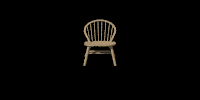

In [10]:
# Load first image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Movement Pictures/ws_chair_movement001.png', grayscale=False)
image1

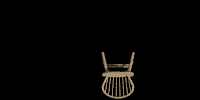

In [11]:
# Load last image for viewing
image1 = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Movement Pictures/ws_chair_movement299.png', grayscale=False)
image1

In [0]:
# Training Set
# To split the data to train 7 models, such that later models have more exposure to more data
# The pictures are NOT to be shuffled, the pictures are modified with increasing variance (in terms of rotation)
# The rotation is only done in one direction, therefore pictures that are the same (rotated 180 degrees) will be removed

# First Run: No Rotated Chairs (Total 150 Images)
# Model 1: Only the original unmodified image (001)
# Model 2: 001 ~ 30  
# Model 3: 001 ~ 60
# Model 4: 001 ~ 90 
# Model 5: 001 ~ 120
# Model 6: 001 ~ 140 # Leave out last 10
# Model 7: 149 ~ 150

# Second Run: With Rotated Chairs (Total 299 Images)
# Model 1: Only the original unmodified image (001)
# Model 2: 001 ~ 60  (Only upright chairs, no rotated chairs)
# Model 3: 001 ~ 120 (Only upright chairs, no rotated chairs)
# Model 4: 001 ~ 180
# Model 5: 001 ~ 240
# Model 6: 001 ~ 290 # Leave out last 9
# Model 7: 150 & 299 # Most Shifted Chair Up & Down

# Test Set
# All models are tested on the entire dataset of 601

In [13]:
# Data input
# Read in the training images
# Values are in RGB from 0 to 255, divide by 255 to get values from 0 to 1

train_image = []
for i in tqdm(range(1,300)):
    if i < 10:
      stringIndex = "00" + str(i)
    elif i < 100:
      stringIndex = "0" + str(i)
    else:
      stringIndex = str(i)

    # Parameter if needed: target_size = rescaled_size
    img = image.load_img('/content/drive/My Drive/Colab Notebooks/4) Movement Pictures/ws_chair_movement' + stringIndex + '.png', grayscale=False)

    img = image.img_to_array(img)
    img = img/255 
    train_image.append(img)

print(len(train_image))
#X = np.array(train_image) # wait for train face image below

100%|██████████| 299/299 [02:04<00:00,  2.40it/s]

299


In [14]:
X = np.array(train_image) # Transfer

# Create y values for training data
# All are 1s, since all are pictures of target chair
y = [1] * 299
y = np.asarray(y)

print(type(X))
print(X.shape)
print(len(X)) # Total length should be 921 training data

print(type(y))
print(y.shape)
print(len(y)) # Total length should be 921 training data


<class 'numpy.ndarray'>
(299, 100, 200, 3)
299
<class 'numpy.ndarray'>
(299,)
299


In [15]:
print(len(X))
print(X.shape)

print(len(y))
print(y.shape)

299
(299, 100, 200, 3)
299
(299,)


In [0]:
# Movement without Flip is technically a subset of Movement With Flip
# Mainly because the 2nd half is the 1st half but inverted
# The first run should only take the first half and exclude the rest

# First Run is for Movement Without Flip
# Not First Run is for Movement With Flip
isFirstRun = True

In [17]:
# First Run is for Movement Without Flip
if(isFirstRun):
  # Split into 6 portions, with the rest as validation sets
  X_train1 = X[0:1]
  X_train2 = X[0:30]
  X_train3 = X[0:60]
  X_train4 = X[0:90]
  X_train5 = X[0:120]
  X_train6 = X[0:140] # Remove last 10 images to set as validation
  X_train7 = X[149:151] # Trained on the last 2 images only, the largest and smallest chair, most modified pictures

  X_train1_flatten = X_train1.reshape(1,flatten_value, 3)
  X_train2_flatten = X_train2.reshape(len(X_train2),flatten_value, 3)
  X_train3_flatten = X_train3.reshape(len(X_train3),flatten_value, 3)
  X_train4_flatten = X_train4.reshape(len(X_train4),flatten_value, 3)
  X_train5_flatten = X_train5.reshape(len(X_train5),flatten_value, 3)
  X_train6_flatten = X_train6.reshape(len(X_train6),flatten_value, 3)
  X_train7_flatten = X_train7.reshape(len(X_train7),flatten_value, 3)

  y_train1 = y[0:1]
  y_train2 = y[0:30]
  y_train3 = y[0:60]
  y_train4 = y[0:90]
  y_train5 = y[0:120]
  y_train6 = y[0:140]
  y_train7 = y[149:151]

  X_val1 = X[1:150]
  X_val2 = X[30:150]
  X_val3 = X[60:150]
  X_val4 = X[90:150]
  X_val5 = X[120:150]
  X_val6 = X[140:150]
  X_val7 = X[0:148]

  X_val1_flatten = X_val1.reshape(len(X_val1),flatten_value, 3)
  X_val2_flatten = X_val2.reshape(len(X_val2),flatten_value, 3)
  X_val3_flatten = X_val3.reshape(len(X_val3),flatten_value, 3)
  X_val4_flatten = X_val4.reshape(len(X_val4),flatten_value, 3)
  X_val5_flatten = X_val5.reshape(len(X_val5),flatten_value, 3)
  X_val6_flatten = X_val6.reshape(len(X_val6),flatten_value, 3)
  X_val7_flatten = X_val7.reshape(len(X_val7),flatten_value, 3)

  y_val1 = y[1:150]
  y_val2 = y[30:150]
  y_val3 = y[60:150]
  y_val4 = y[90:150]
  y_val5 = y[120:150]
  y_val6 = y[140:150]
  y_val7 = y[0:148]

  print("X Length")
  print(len(X))

  print("X Train Length")
  print(len(X_train1))
  print(len(X_train2))
  print(len(X_train3))
  print(len(X_train4))
  print(len(X_train5))
  print(len(X_train6))
  print(len(X_train7))

  print("X_train shape")
  print(X_train1.shape)
  print(X_train2.shape)
  print(X_train3.shape)
  print(X_train4.shape)
  print(X_train5.shape)
  print(X_train6.shape)
  print(X_train7.shape)

  print("X_train flatten")
  print(X_train1_flatten.shape)
  print(X_train2_flatten.shape)
  print(X_train3_flatten.shape)
  print(X_train4_flatten.shape)
  print(X_train5_flatten.shape)
  print(X_train6_flatten.shape)
  print(X_train7_flatten.shape)

  print("X_val shape")
  print(X_val1.shape)
  print(X_val2.shape)
  print(X_val3.shape)
  print(X_val4.shape)
  print(X_val5.shape)
  print(X_val6.shape)
  print(X_val7.shape)

  print("X_val flatten")
  print(X_val1_flatten.shape)
  print(X_val2_flatten.shape)
  print(X_val3_flatten.shape)
  print(X_val4_flatten.shape)
  print(X_val5_flatten.shape)
  print(X_val6_flatten.shape)
  print(X_val7_flatten.shape)

  print("Data Prepared")
  print("First Run")

X Length
299
X Train Length
1
30
60
90
120
140
2
X_train shape
(1, 100, 200, 3)
(30, 100, 200, 3)
(60, 100, 200, 3)
(90, 100, 200, 3)
(120, 100, 200, 3)
(140, 100, 200, 3)
(2, 100, 200, 3)
X_train flatten
(1, 20000, 3)
(30, 20000, 3)
(60, 20000, 3)
(90, 20000, 3)
(120, 20000, 3)
(140, 20000, 3)
(2, 20000, 3)
X_val shape
(149, 100, 200, 3)
(120, 100, 200, 3)
(90, 100, 200, 3)
(60, 100, 200, 3)
(30, 100, 200, 3)
(10, 100, 200, 3)
(148, 100, 200, 3)
X_val flatten
(149, 20000, 3)
(120, 20000, 3)
(90, 20000, 3)
(60, 20000, 3)
(30, 20000, 3)
(10, 20000, 3)
(148, 20000, 3)
Data Prepared
First Run


In [0]:
print(X.shape)
#index = [150,299]
a = X[150]
b = X[298]
ab = [a,b]
XTrain_for_model7 = np.array(ab)
print(XTrain_for_model7.shape)

(299, 100, 200, 3)
(2, 100, 200, 3)


In [0]:
print(X.shape)
#index = [149,298]
XVal_for_model7 = np.delete(X, 149,0)
print(XVal_for_model7.shape)
XVal_for_model7 = np.delete(XVal_for_model7, 297,0) # Move one down, array size reduced
print(XVal_for_model7.shape)

(299, 100, 200, 3)
(298, 100, 200, 3)
(297, 100, 200, 3)


In [0]:
# Not First Run is for Movement With Flip
if(not isFirstRun):
  # Split into 6 portions, with the rest as validation sets
  X_train1 = X[0:1]
  X_train2 = X[0:60]
  X_train3 = X[0:120]
  X_train4 = X[0:180]
  X_train5 = X[0:240]
  X_train6 = X[0:290] # Remove last 9 images to set as validation
  X_train7 = XTrain_for_model7 # Trained on the last 2 images only, the largest and smallest chair, most modified pictures

  X_train1_flatten = X_train1.reshape(1,flatten_value, 3)
  X_train2_flatten = X_train2.reshape(len(X_train2),flatten_value, 3)
  X_train3_flatten = X_train3.reshape(len(X_train3),flatten_value, 3)
  X_train4_flatten = X_train4.reshape(len(X_train4),flatten_value, 3)
  X_train5_flatten = X_train5.reshape(len(X_train5),flatten_value, 3)
  X_train6_flatten = X_train6.reshape(len(X_train6),flatten_value, 3)
  X_train7_flatten = X_train7.reshape(len(X_train7),flatten_value, 3)

  y_train1 = y[0:1]
  y_train2 = y[0:60]
  y_train3 = y[0:120]
  y_train4 = y[0:180]
  y_train5 = y[0:240]
  y_train6 = y[0:290]
  y_train7 = y[297:299] # Get 2 values 

  X_val1 = X[1:299]
  X_val2 = X[60:299]
  X_val3 = X[120:299]
  X_val4 = X[180:299]
  X_val5 = X[240:299]
  X_val6 = X[290:299]
  X_val7 = XVal_for_model7

  X_val1_flatten = X_val1.reshape(len(X_val1),flatten_value, 3)
  X_val2_flatten = X_val2.reshape(len(X_val2),flatten_value, 3)
  X_val3_flatten = X_val3.reshape(len(X_val3),flatten_value, 3)
  X_val4_flatten = X_val4.reshape(len(X_val4),flatten_value, 3)
  X_val5_flatten = X_val5.reshape(len(X_val5),flatten_value, 3)
  X_val6_flatten = X_val6.reshape(len(X_val6),flatten_value, 3)
  X_val7_flatten = X_val7.reshape(len(X_val7),flatten_value, 3)

  y_val1 = y[1:299]
  y_val2 = y[60:299]
  y_val3 = y[120:299]
  y_val4 = y[180:299]
  y_val5 = y[240:299]
  y_val6 = y[290:299]
  y_val7 = y[0:297] # Get N - 2 values 

  print("X Length")
  print(len(X))

  print("X Train Length")
  print(len(X_train1))
  print(len(X_train2))
  print(len(X_train3))
  print(len(X_train4))
  print(len(X_train5))
  print(len(X_train6))
  print(len(X_train7))

  print("X_train shape")
  print(X_train1.shape)
  print(X_train2.shape)
  print(X_train3.shape)
  print(X_train4.shape)
  print(X_train5.shape)
  print(X_train6.shape)
  print(X_train7.shape)

  print("X_train flatten")
  print(X_train1_flatten.shape)
  print(X_train2_flatten.shape)
  print(X_train3_flatten.shape)
  print(X_train4_flatten.shape)
  print(X_train5_flatten.shape)
  print(X_train6_flatten.shape)
  print(X_train7_flatten.shape)

  print("X_val shape")
  print(X_val1.shape)
  print(X_val2.shape)
  print(X_val3.shape)
  print(X_val4.shape)
  print(X_val5.shape)
  print(X_val6.shape)
  print(X_val7.shape)

  print("X_val flatten")
  print(X_val1_flatten.shape)
  print(X_val2_flatten.shape)
  print(X_val3_flatten.shape)
  print(X_val4_flatten.shape)
  print(X_val5_flatten.shape)
  print(X_val6_flatten.shape)
  print(X_val7_flatten.shape)

  print("Data Prepared")
  print("Second Run")

X Length
299
X Train Length
1
60
120
180
240
290
2
X_train shape
(1, 100, 200, 3)
(60, 100, 200, 3)
(120, 100, 200, 3)
(180, 100, 200, 3)
(240, 100, 200, 3)
(290, 100, 200, 3)
(2, 100, 200, 3)
X_train flatten
(1, 20000, 3)
(60, 20000, 3)
(120, 20000, 3)
(180, 20000, 3)
(240, 20000, 3)
(290, 20000, 3)
(2, 20000, 3)
X_val shape
(298, 100, 200, 3)
(239, 100, 200, 3)
(179, 100, 200, 3)
(119, 100, 200, 3)
(59, 100, 200, 3)
(9, 100, 200, 3)
(297, 100, 200, 3)
X_val flatten
(298, 20000, 3)
(239, 20000, 3)
(179, 20000, 3)
(119, 20000, 3)
(59, 20000, 3)
(9, 20000, 3)
(297, 20000, 3)
Data Prepared
Second Run


In [0]:
print("y_train")
print(y_train1.shape)
print(y_train2.shape)
print(y_train3.shape)
print(y_train4.shape)
print(y_train5.shape)
print(y_train6.shape)
print(y_train7.shape)

print("y_val")
print(y_val1.shape)
print(y_val2.shape)
print(y_val3.shape)
print(y_val4.shape)
print(y_val5.shape)
print(y_val6.shape)
print(y_val7.shape)

y_train
(1,)
(60,)
(120,)
(180,)
(240,)
(290,)
(2,)
y_val
(298,)
(239,)
(179,)
(119,)
(59,)
(9,)
(297,)


In [0]:
# Clear Variables no longer needed
train_image = None
X = None
y = None
a = None
b = None
ab = None
XTrain_for_model7 = None
XVal_for_model7 = None

In [0]:
###########################################################################################################################
#------------------------------------------------------------Model Building-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters
batch_size_user = 2
epoch_user = 1
times_to_loop_model = 3

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
2
1
3


In [0]:
###########################################################################################################################
#------------------------------------------------------------Dense Model-----------------------------------------------#
###########################################################################################################################

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 1s 848ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.7001 - val_acc: 0.2819
(298, 1)


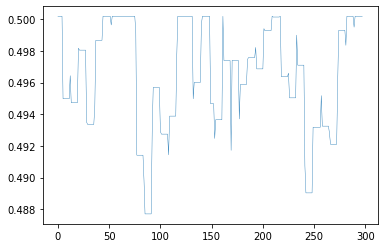

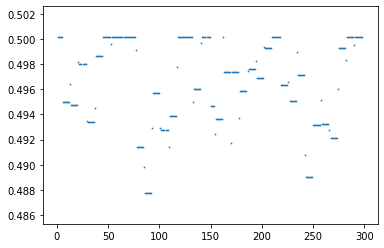

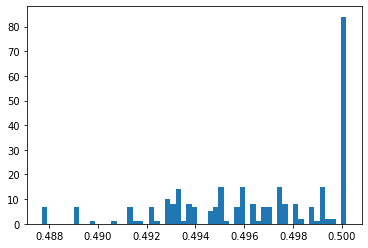

Average value is:  0.49652264
Total Predicted Positive:  159  out of  298
53.355704697986575 %
Epoch:  2
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 0s 279ms/step - loss: 0.6928 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.2819
(298, 1)


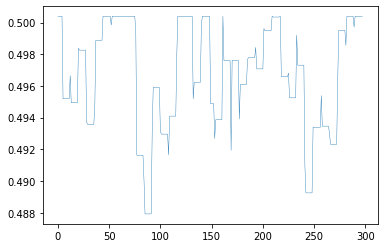

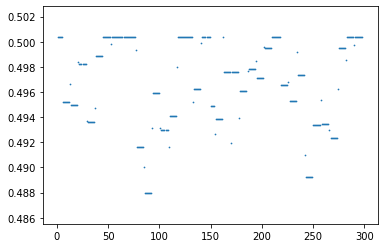

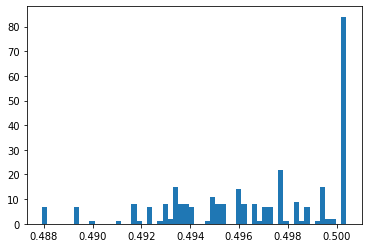

Average value is:  0.49673727
Total Predicted Positive:  159  out of  298
53.355704697986575 %
Epoch:  3
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 0s 280ms/step - loss: 0.6923 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.2886
(298, 1)


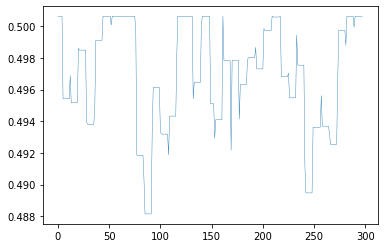

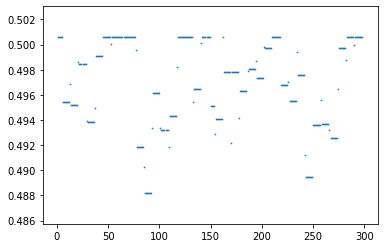

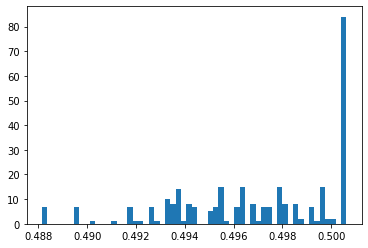

Average value is:  0.4969647
Total Predicted Positive:  159  out of  298
53.355704697986575 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 1
## create the model
modelDense1 = 0
modelDense1 = Sequential()
modelDense1.add(Flatten())
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(2, activation='relu'))
modelDense1.add(Dense(1, activation='sigmoid'))
modelDense1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense1.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelDense1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 1s 19ms/step - loss: 0.6861 - acc: 0.9667 - val_loss: 0.6783 - val_acc: 1.0000
(239, 1)


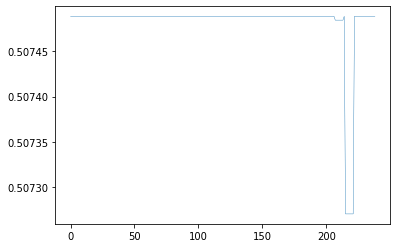

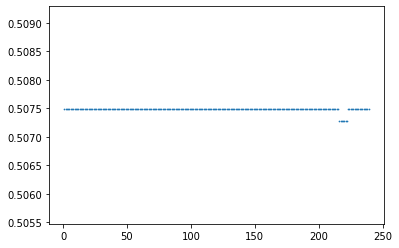

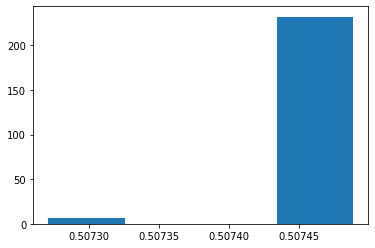

Average value is:  0.50748193
Total Predicted Positive:  232  out of  239
97.07112970711297 %
Epoch:  2
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 0s 6ms/step - loss: 0.6712 - acc: 1.0000 - val_loss: 0.6637 - val_acc: 1.0000
(239, 1)


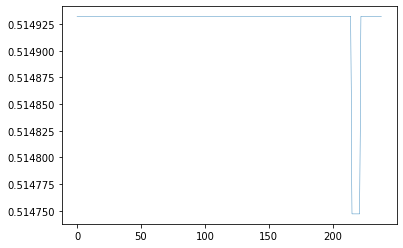

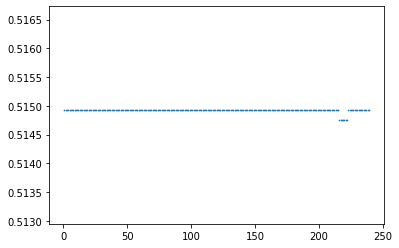

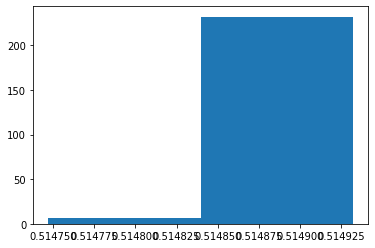

Average value is:  0.51492673
Total Predicted Positive:  232  out of  239
97.07112970711297 %
Epoch:  3
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 0s 6ms/step - loss: 0.6568 - acc: 1.0000 - val_loss: 0.6495 - val_acc: 1.0000
(239, 1)


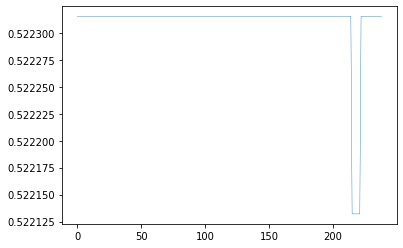

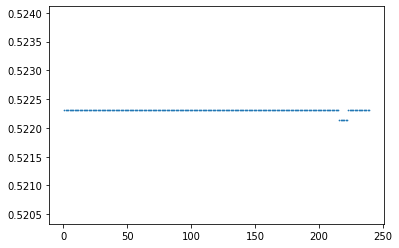

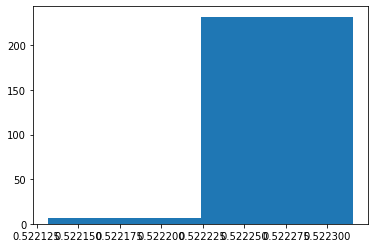

Average value is:  0.5223101
Total Predicted Positive:  232  out of  239
97.07112970711297 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 2
## create the model
modelDense2 = 0
modelDense2 = Sequential()
modelDense2.add(Flatten())
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(2, activation='relu'))
modelDense2.add(Dense(1, activation='sigmoid'))
modelDense2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense2.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelDense2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 60000)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 1s 10ms/step - loss: 0.6788 - acc: 0.9750 - val_loss: 0.6644 - val_acc: 1.0000
(179, 1)


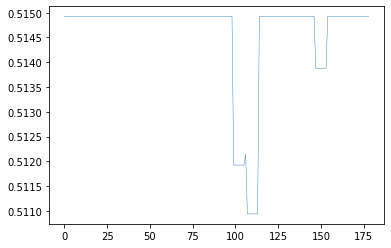

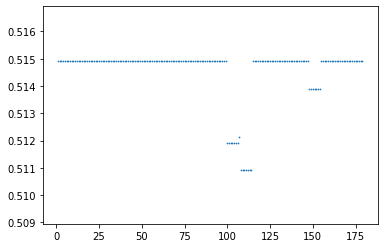

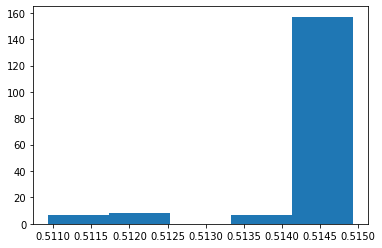

Average value is:  0.51459885
Total Predicted Positive:  157  out of  179
87.70949720670392 %
Epoch:  2
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 0s 4ms/step - loss: 0.6498 - acc: 1.0000 - val_loss: 0.6362 - val_acc: 1.0000
(179, 1)


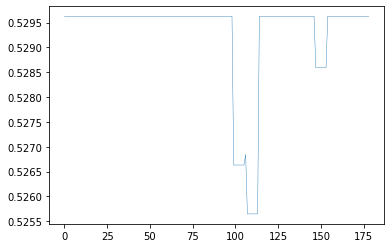

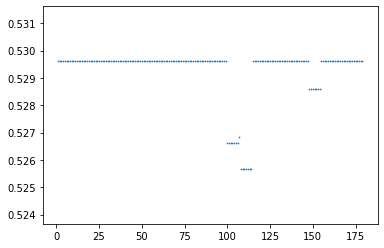

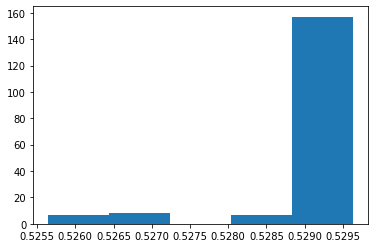

Average value is:  0.52930015
Total Predicted Positive:  157  out of  179
87.70949720670392 %
Epoch:  3
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 0s 3ms/step - loss: 0.6223 - acc: 1.0000 - val_loss: 0.6093 - val_acc: 1.0000
(179, 1)


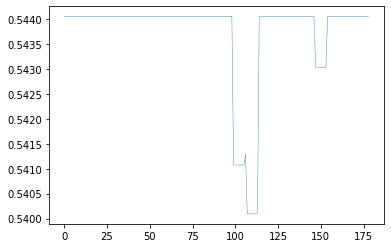

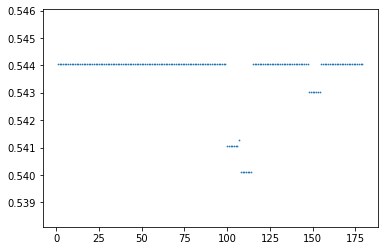

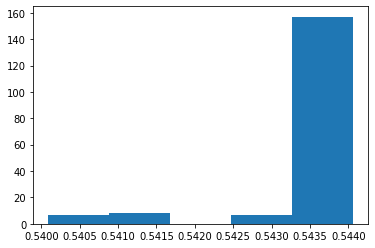

Average value is:  0.54372984
Total Predicted Positive:  157  out of  179
87.70949720670392 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 3
## create the model
modelDense3 = 0
modelDense3 = Sequential()
modelDense3.add(Flatten())
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(2, activation='relu'))
modelDense3.add(Dense(1, activation='sigmoid'))
modelDense3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense3.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelDense3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 60000)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 1s 7ms/step - loss: 0.6717 - acc: 0.9778 - val_loss: 0.6506 - val_acc: 1.0000
(119, 1)


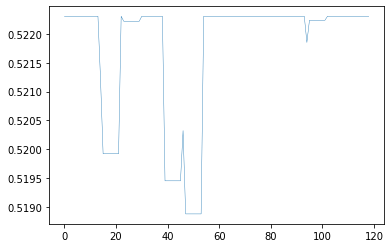

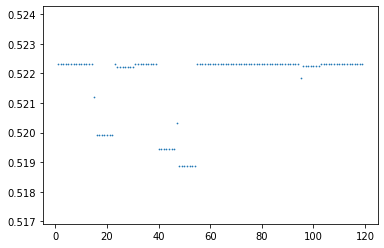

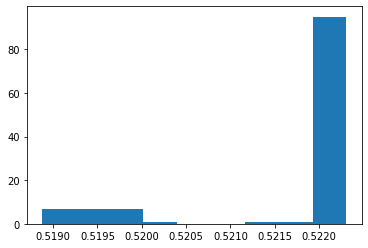

Average value is:  0.52175814
Total Predicted Positive:  96  out of  119
80.67226890756302 %
Epoch:  2
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 0s 2ms/step - loss: 0.6290 - acc: 1.0000 - val_loss: 0.6096 - val_acc: 1.0000
(119, 1)


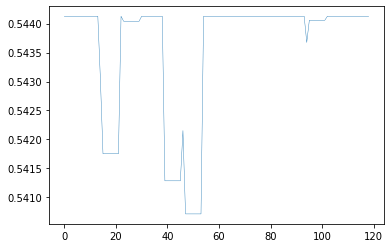

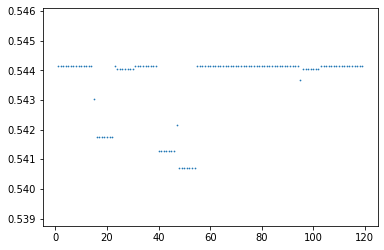

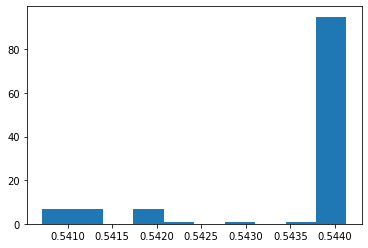

Average value is:  0.54358083
Total Predicted Positive:  96  out of  119
80.67226890756302 %
Epoch:  3
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 0s 2ms/step - loss: 0.5895 - acc: 1.0000 - val_loss: 0.5714 - val_acc: 1.0000
(119, 1)


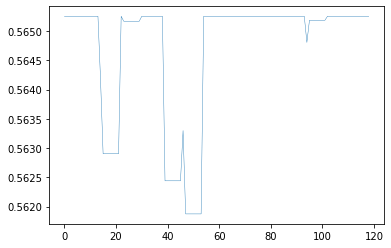

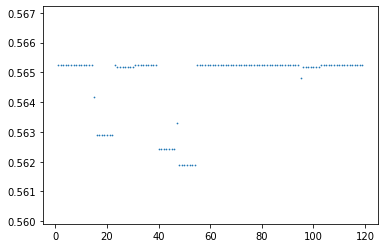

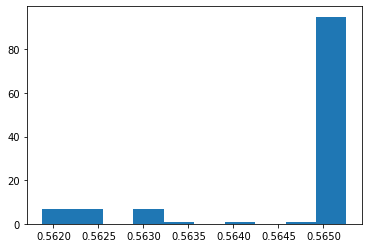

Average value is:  0.5647143
Total Predicted Positive:  96  out of  119
80.67226890756302 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 4
## create the model
modelDense4 = 0
modelDense4 = Sequential()
modelDense4.add(Flatten())
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(2, activation='relu'))
modelDense4.add(Dense(1, activation='sigmoid'))
modelDense4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense4.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelDense4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 60000)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 1s 5ms/step - loss: 0.6644 - acc: 0.9875 - val_loss: 0.6355 - val_acc: 1.0000
(59, 1)


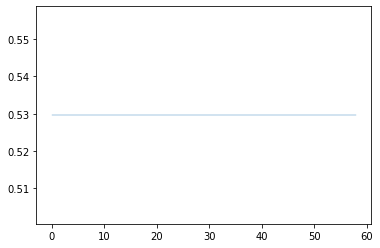

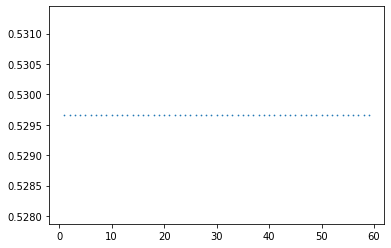

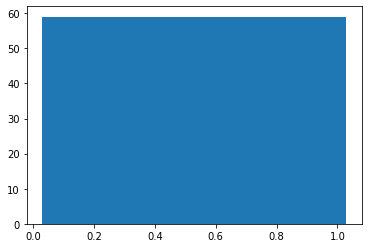

Average value is:  0.52965933
Total Predicted Positive:  59  out of  59
100.0 %
Epoch:  2
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 1s 2ms/step - loss: 0.6090 - acc: 1.0000 - val_loss: 0.5829 - val_acc: 1.0000
(59, 1)


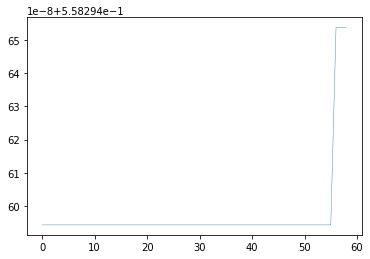

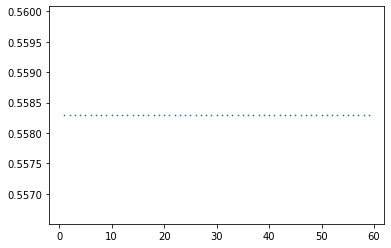

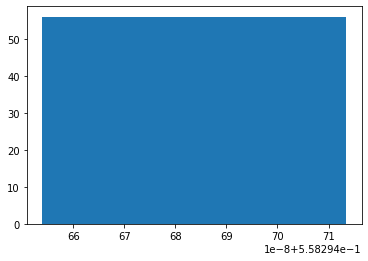

Average value is:  0.5582946
Total Predicted Positive:  59  out of  59
100.0 %
Epoch:  3
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 1s 2ms/step - loss: 0.5588 - acc: 1.0000 - val_loss: 0.5350 - val_acc: 1.0000
(59, 1)


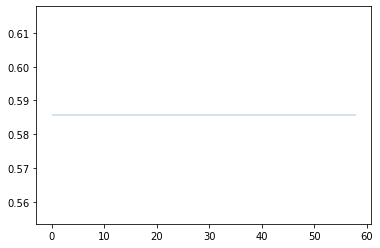

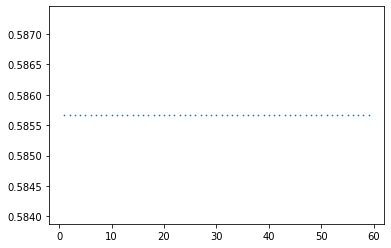

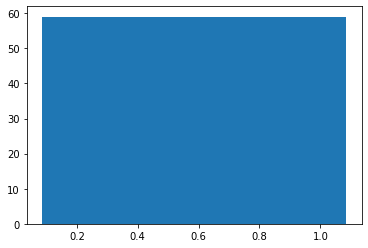

Average value is:  0.5856658
Total Predicted Positive:  59  out of  59
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 5
## create the model
modelDense5 = 0
modelDense5 = Sequential()
modelDense5.add(Flatten())
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(2, activation='relu'))
modelDense5.add(Dense(1, activation='sigmoid'))
modelDense5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense5.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelDense5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 60000)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 1s 5ms/step - loss: 0.6584 - acc: 0.9931 - val_loss: 0.6242 - val_acc: 1.0000
(9, 1)


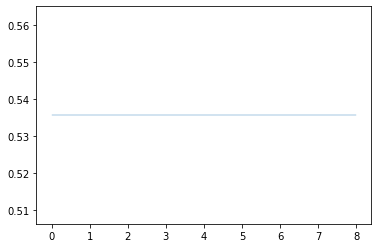

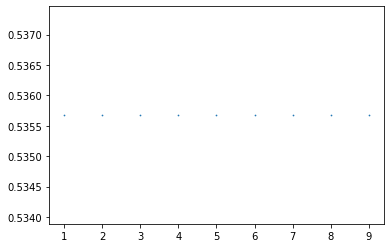

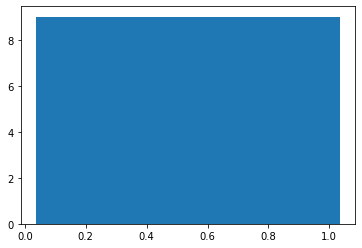

Average value is:  0.5356753
Total Predicted Positive:  9  out of  9
100.0 %
Epoch:  2
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 1s 2ms/step - loss: 0.5930 - acc: 1.0000 - val_loss: 0.5626 - val_acc: 1.0000
(9, 1)


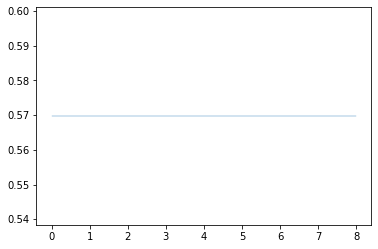

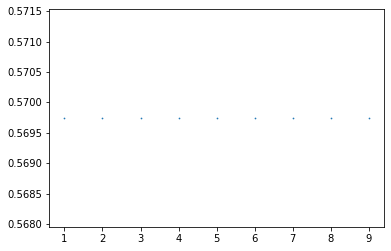

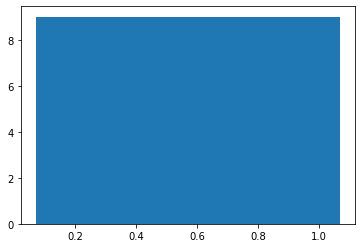

Average value is:  0.56974155
Total Predicted Positive:  9  out of  9
100.0 %
Epoch:  3
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 1s 2ms/step - loss: 0.5347 - acc: 1.0000 - val_loss: 0.5076 - val_acc: 1.0000
(9, 1)


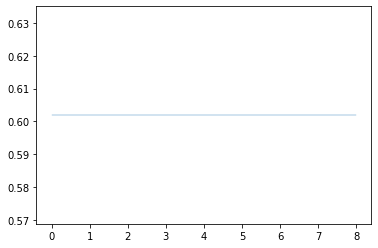

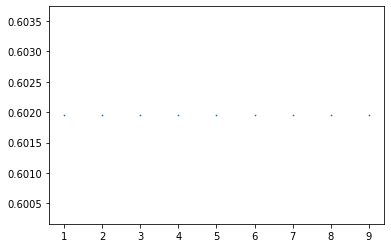

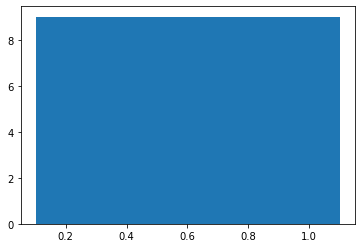

Average value is:  0.60195273
Total Predicted Positive:  9  out of  9
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 6
## create the model
modelDense6 = 0
modelDense6 = Sequential()
modelDense6.add(Flatten())
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(2, activation='relu'))
modelDense6.add(Dense(1, activation='sigmoid'))
modelDense6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense6.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelDense6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 60000)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 120002    
_________________________________________________________________
dense_41 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 3         
Total params: 120,011
Trainable params: 120,011
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 1s 571ms/step - loss: 0.6987 - acc: 0.0000e+00 - val_loss: 0.6952 - val_acc: 0.6734
(297, 1)


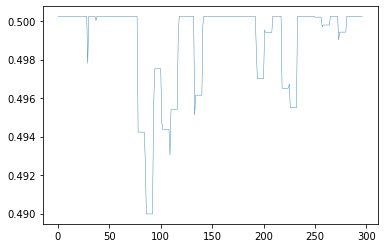

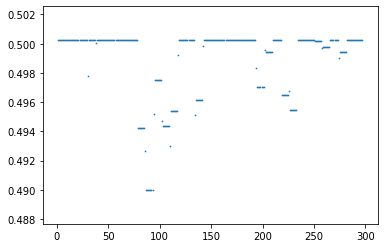

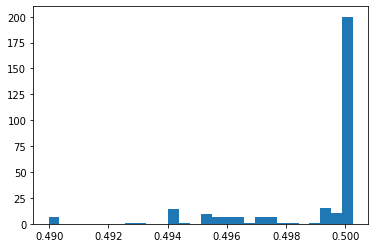

Average value is:  0.49898112
Total Predicted Positive:  226  out of  297
76.0942760942761 %
Epoch:  2
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 0s 145ms/step - loss: 0.6926 - acc: 1.0000 - val_loss: 0.6943 - val_acc: 0.7037
(297, 1)


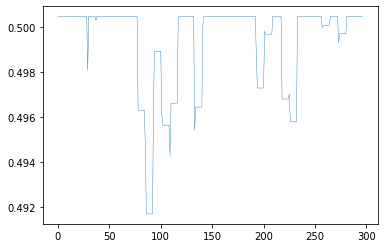

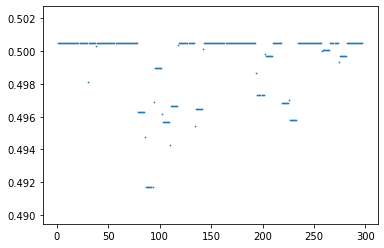

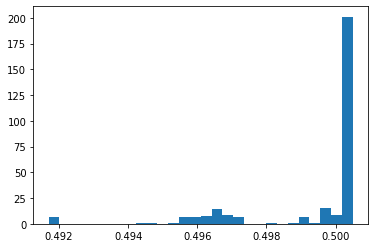

Average value is:  0.49941543
Total Predicted Positive:  225  out of  297
75.75757575757575 %
Epoch:  3
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 0s 147ms/step - loss: 0.6921 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.7576
(297, 1)


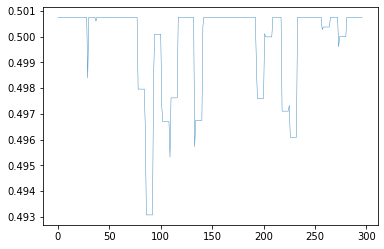

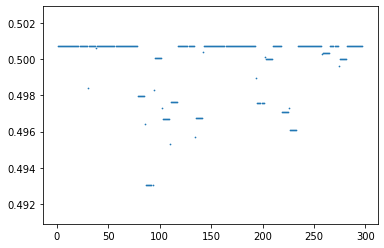

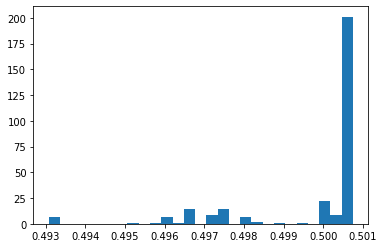

Average value is:  0.49980435
Total Predicted Positive:  232  out of  297
78.11447811447812 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## Dense Model 7
## create the model
modelDense7 = 0
modelDense7 = Sequential()
modelDense7.add(Flatten())
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(2, activation='relu'))
modelDense7.add(Dense(1, activation='sigmoid'))
modelDense7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelDense7.build(input_shape) # `input_shape` is the shape of the input data

print(modelDense7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelDense7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelDense7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------CNN Model-----------------------------------------------#
###########################################################################################################################


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.6687 - acc: 1.0000 - val_loss: 0.6511 - val_acc: 0.5906
(298, 1)


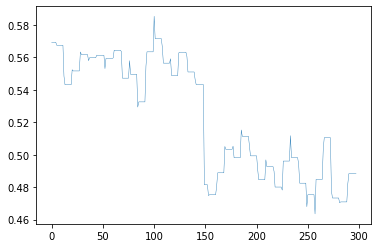

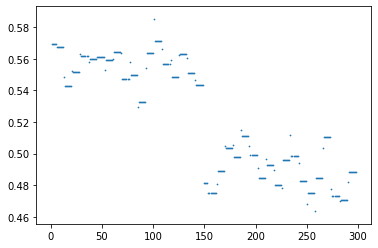

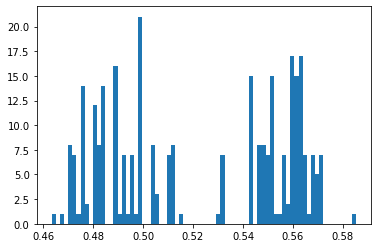

Average value is:  0.5226635
Total Predicted Positive:  149  out of  298
50.0 %
Epoch:  2
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 0s 308ms/step - loss: 0.5636 - acc: 1.0000 - val_loss: 0.5765 - val_acc: 0.9966
(298, 1)


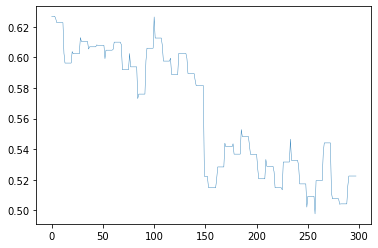

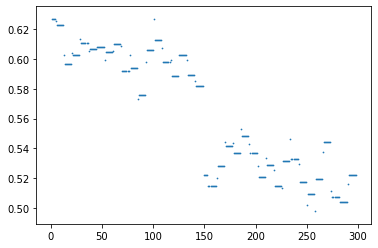

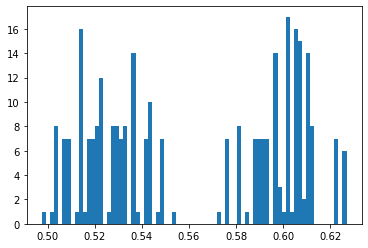

Average value is:  0.5632902
Total Predicted Positive:  149  out of  298
50.0 %
Epoch:  3
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 0s 326ms/step - loss: 0.4670 - acc: 1.0000 - val_loss: 0.4983 - val_acc: 1.0000
(298, 1)


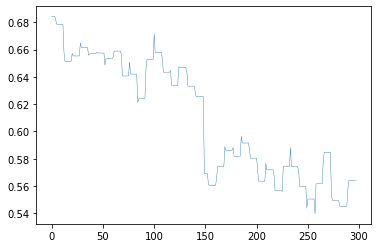

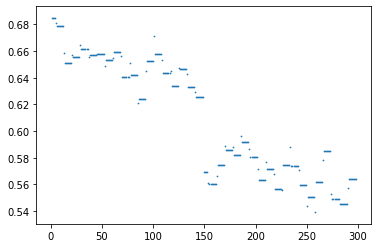

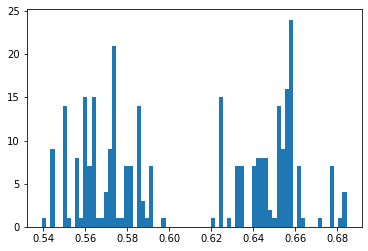

Average value is:  0.60908496
Total Predicted Positive:  149  out of  298
50.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 1
## create the model
modelCNN1 = 0
modelCNN1 = Sequential()
modelCNN1.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN1.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN1.add(Flatten())
modelCNN1.add(Dense(1, activation='sigmoid'))
modelCNN1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN1.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN1.fit(X_train1, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1, y_val1),verbose=1)

  # Test the model
  y_pred = modelCNN1.predict(X_val1)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 1s 22ms/step - loss: 0.1051 - acc: 1.0000 - val_loss: 6.2668e-05 - val_acc: 1.0000
(239, 1)


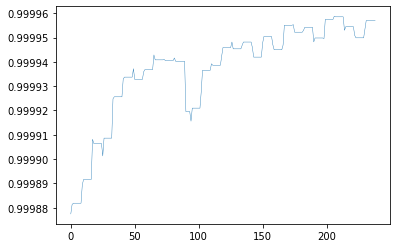

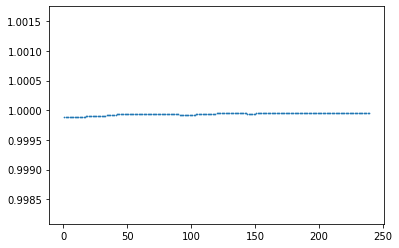

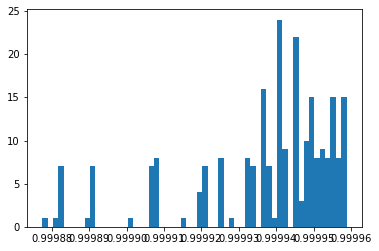

Average value is:  0.99993724
Total Predicted Positive:  154  out of  239
64.43514644351464 %
Epoch:  2
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 0s 6ms/step - loss: 4.0413e-05 - acc: 1.0000 - val_loss: 1.1414e-05 - val_acc: 1.0000
(239, 1)


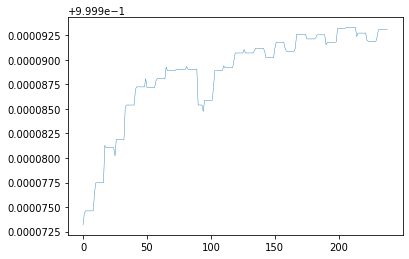

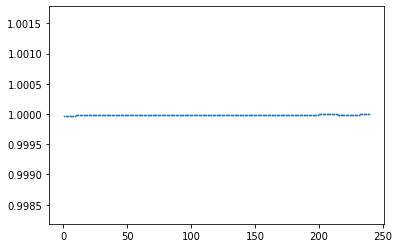

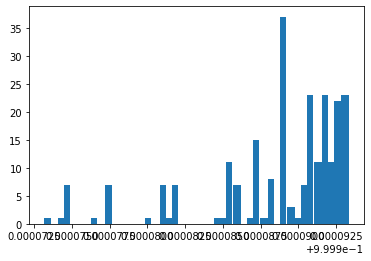

Average value is:  0.9999885
Total Predicted Positive:  161  out of  239
67.36401673640168 %
Epoch:  3
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 0s 6ms/step - loss: 2.0470e-05 - acc: 1.0000 - val_loss: 9.8381e-06 - val_acc: 1.0000
(239, 1)


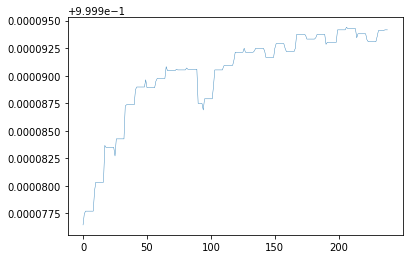

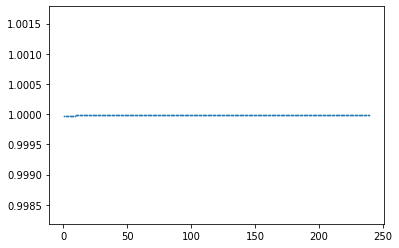

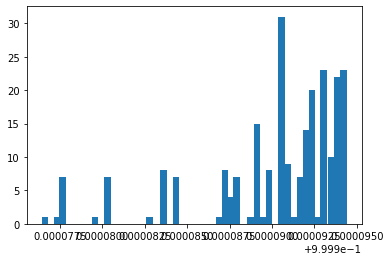

Average value is:  0.99999017
Total Predicted Positive:  161  out of  239
67.36401673640168 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 2
## create the model
modelCNN2 = 0
modelCNN2 = Sequential()
modelCNN2.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN2.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN2.add(Flatten())
modelCNN2.add(Dense(1, activation='sigmoid'))
modelCNN2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN2.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN2.fit(X_train2, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2, y_val2),verbose=1)

  # Test the model
  y_pred = modelCNN2.predict(X_val2)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 1s 12ms/step - loss: 0.0623 - acc: 0.9917 - val_loss: 8.0363e-06 - val_acc: 1.0000
(179, 1)


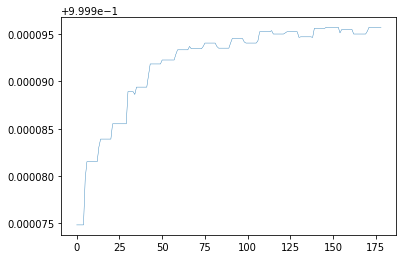

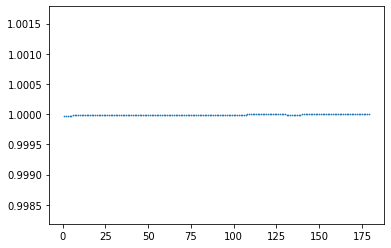

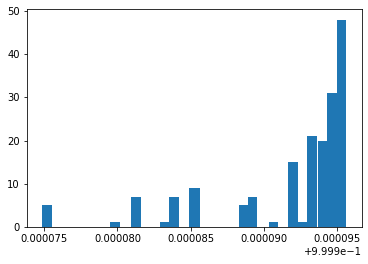

Average value is:  0.999992
Total Predicted Positive:  129  out of  179
72.06703910614524 %
Epoch:  2
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 0s 3ms/step - loss: 1.8061e-05 - acc: 1.0000 - val_loss: 6.3734e-06 - val_acc: 1.0000
(179, 1)


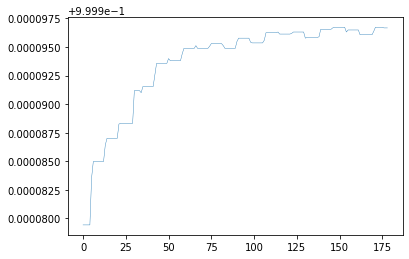

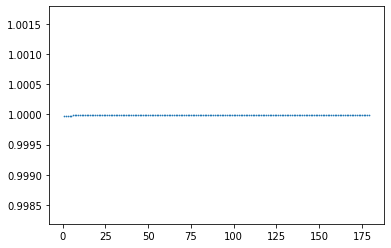

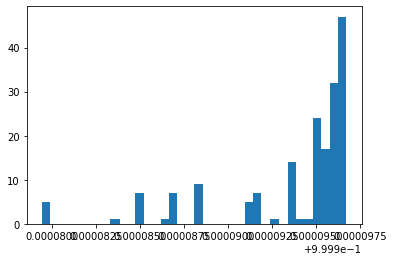

Average value is:  0.9999937
Total Predicted Positive:  129  out of  179
72.06703910614524 %
Epoch:  3
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 0s 3ms/step - loss: 1.6050e-05 - acc: 1.0000 - val_loss: 5.5995e-06 - val_acc: 1.0000
(179, 1)


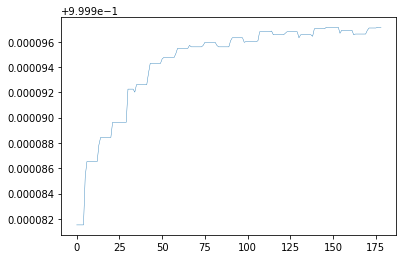

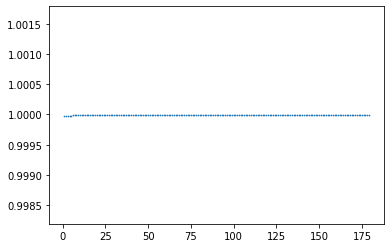

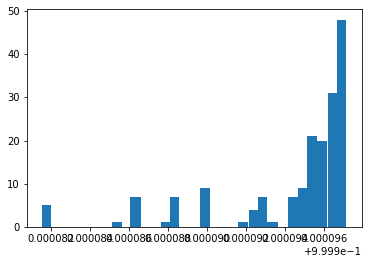

Average value is:  0.9999944
Total Predicted Positive:  129  out of  179
72.06703910614524 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 3
## create the model
modelCNN3 = 0
modelCNN3 = Sequential()
modelCNN3.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN3.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN3.add(Flatten())
modelCNN3.add(Dense(1, activation='sigmoid'))
modelCNN3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN3.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN3.fit(X_train3, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3, y_val3),verbose=1)

  # Test the model
  y_pred = modelCNN3.predict(X_val3)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 2s 8ms/step - loss: 0.0391 - acc: 1.0000 - val_loss: 2.0944e-05 - val_acc: 1.0000
(119, 1)


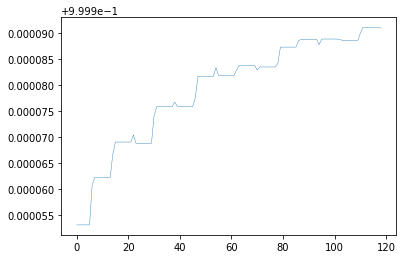

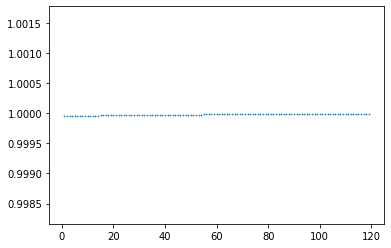

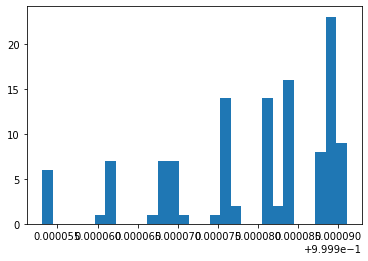

Average value is:  0.99997914
Total Predicted Positive:  72  out of  119
60.50420168067227 %
Epoch:  2
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 0s 3ms/step - loss: 2.9364e-05 - acc: 1.0000 - val_loss: 1.6631e-05 - val_acc: 1.0000
(119, 1)


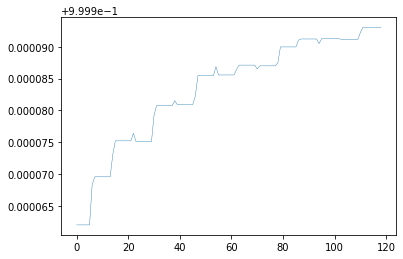

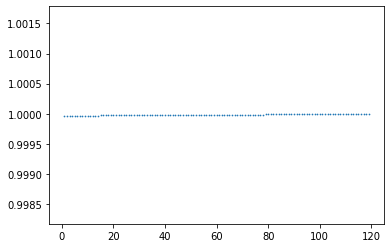

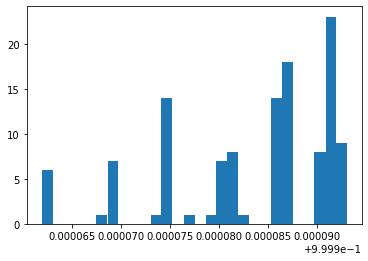

Average value is:  0.9999834
Total Predicted Positive:  72  out of  119
60.50420168067227 %
Epoch:  3
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 0s 3ms/step - loss: 2.3868e-05 - acc: 1.0000 - val_loss: 1.3031e-05 - val_acc: 1.0000
(119, 1)


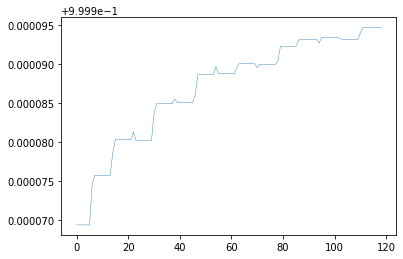

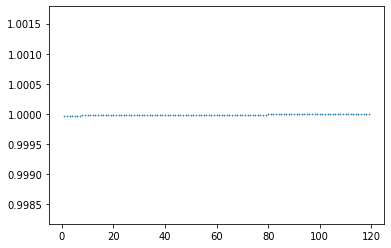

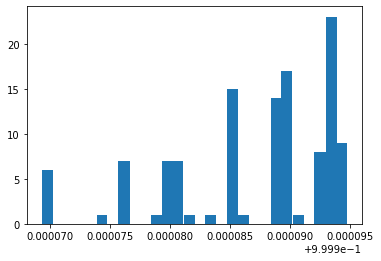

Average value is:  0.9999868
Total Predicted Positive:  72  out of  119
60.50420168067227 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 4
## create the model
modelCNN4 = 0
modelCNN4 = Sequential()
modelCNN4.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN4.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN4.add(Flatten())
modelCNN4.add(Dense(1, activation='sigmoid'))
modelCNN4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN4.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN4.fit(X_train4, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4, y_val4),verbose=1)

  # Test the model
  y_pred = modelCNN4.predict(X_val4)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 2s 7ms/step - loss: 0.0328 - acc: 0.9958 - val_loss: 2.9647e-05 - val_acc: 1.0000
(59, 1)


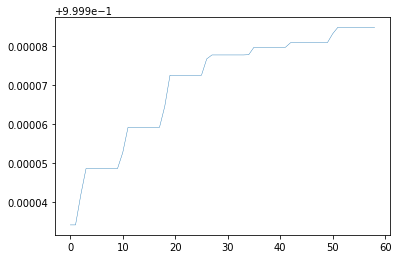

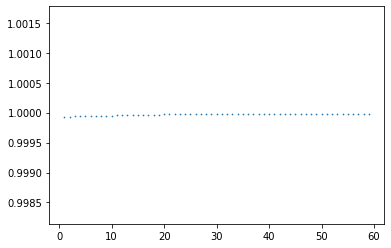

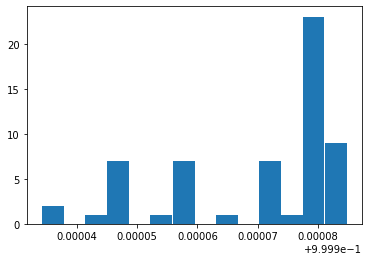

Average value is:  0.9999704
Total Predicted Positive:  40  out of  59
67.79661016949152 %
Epoch:  2
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 1s 2ms/step - loss: 2.1863e-05 - acc: 1.0000 - val_loss: 2.1125e-05 - val_acc: 1.0000
(59, 1)


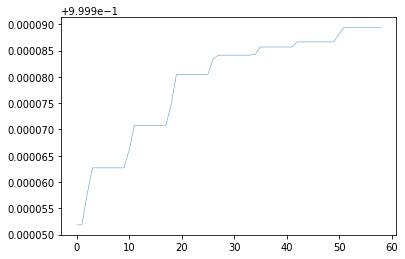

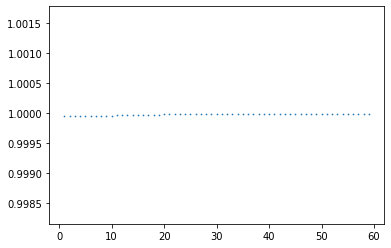

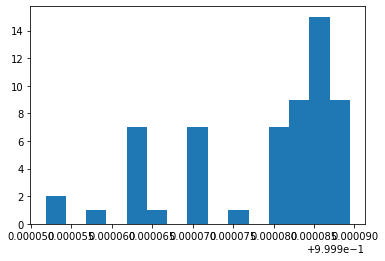

Average value is:  0.9999788
Total Predicted Positive:  40  out of  59
67.79661016949152 %
Epoch:  3
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 1s 2ms/step - loss: 1.5899e-05 - acc: 1.0000 - val_loss: 1.5105e-05 - val_acc: 1.0000
(59, 1)


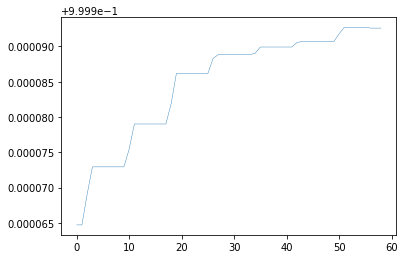

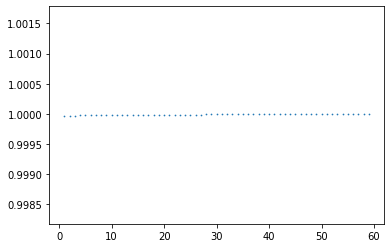

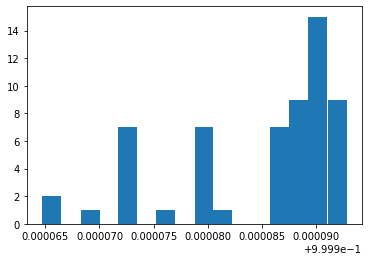

Average value is:  0.99998486
Total Predicted Positive:  40  out of  59
67.79661016949152 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 5
## create the model
modelCNN5 = 0
modelCNN5 = Sequential()
modelCNN5.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN5.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN5.add(Flatten())
modelCNN5.add(Dense(1, activation='sigmoid'))
modelCNN5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN5.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN5.fit(X_train5, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5, y_val5),verbose=1)

  # Test the model
  y_pred = modelCNN5.predict(X_val5)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 2s 6ms/step - loss: 0.0316 - acc: 0.9931 - val_loss: 1.6822e-05 - val_acc: 1.0000
(9, 1)


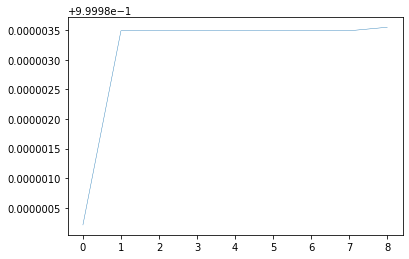

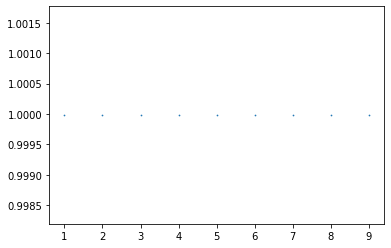

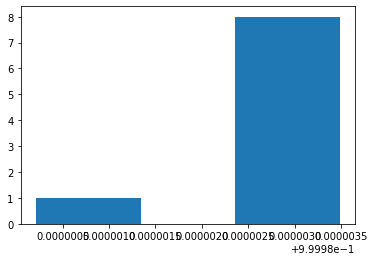

Average value is:  0.99998313
Total Predicted Positive:  8  out of  9
88.88888888888889 %
Epoch:  2
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 1s 2ms/step - loss: 1.2252e-05 - acc: 1.0000 - val_loss: 1.2080e-05 - val_acc: 1.0000
(9, 1)


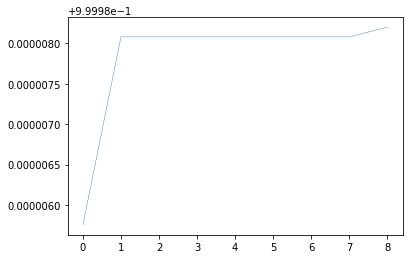

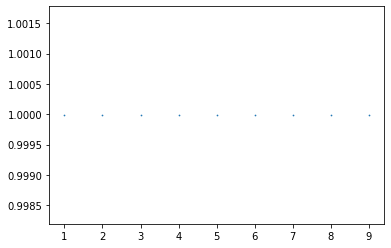

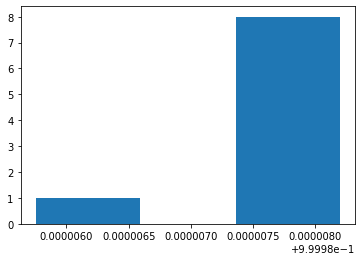

Average value is:  0.99998784
Total Predicted Positive:  8  out of  9
88.88888888888889 %
Epoch:  3
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 1s 2ms/step - loss: 8.8676e-06 - acc: 1.0000 - val_loss: 8.5434e-06 - val_acc: 1.0000
(9, 1)


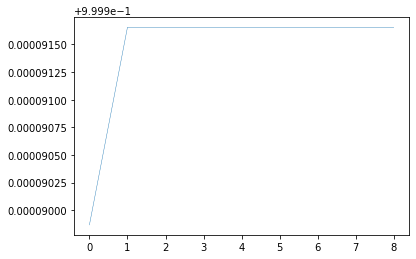

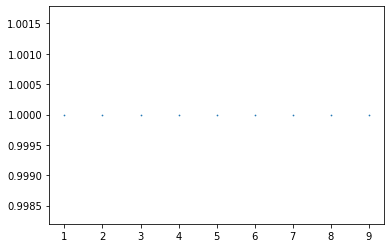

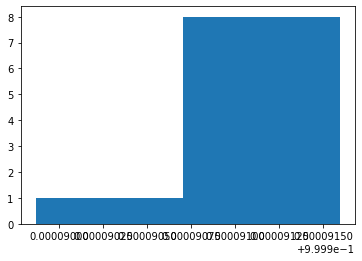

Average value is:  0.9999914
Total Predicted Positive:  8  out of  9
88.88888888888889 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 6
## create the model
modelCNN6 = 0
modelCNN6 = Sequential()
modelCNN6.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN6.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN6.add(Flatten())
modelCNN6.add(Dense(1, activation='sigmoid'))
modelCNN6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN6.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN6.fit(X_train6, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6, y_val6),verbose=1)

  # Test the model
  y_pred = modelCNN6.predict(X_val6)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 99, 199, 4)        52        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 99, 4)         0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 19404)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 19405     
Total params: 19,457
Trainable params: 19,457
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 2s 767ms/step - loss: 0.7464 - acc: 0.0000e+00 - val_loss: 0.6312 - val_acc: 1.0000
(297, 1)


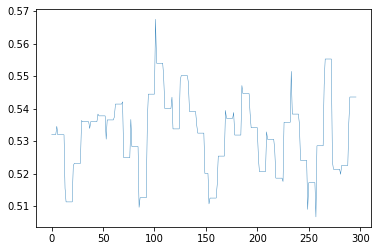

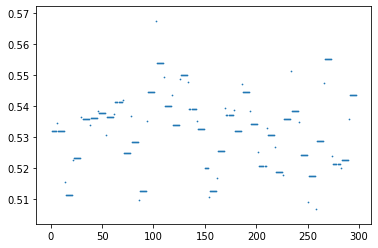

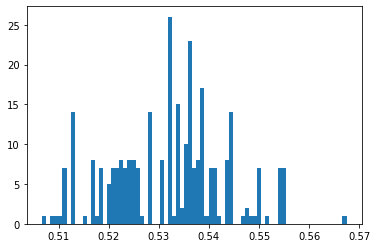

Average value is:  0.532059
Total Predicted Positive:  161  out of  297
54.20875420875421 %
Epoch:  2
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 0s 156ms/step - loss: 0.6317 - acc: 1.0000 - val_loss: 0.5577 - val_acc: 1.0000
(297, 1)


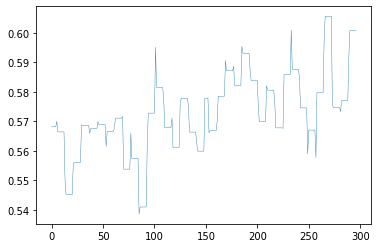

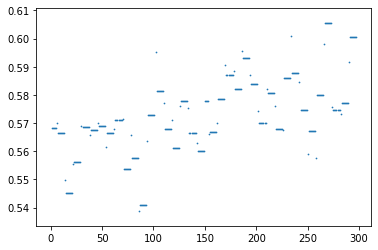

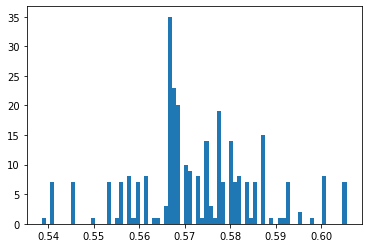

Average value is:  0.5726897
Total Predicted Positive:  140  out of  297
47.13804713804714 %
Epoch:  3
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 0s 160ms/step - loss: 0.5290 - acc: 1.0000 - val_loss: 0.4853 - val_acc: 1.0000
(297, 1)


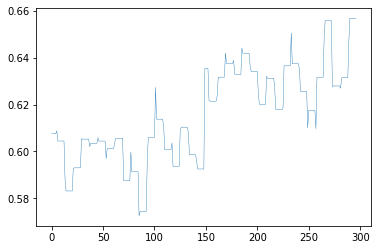

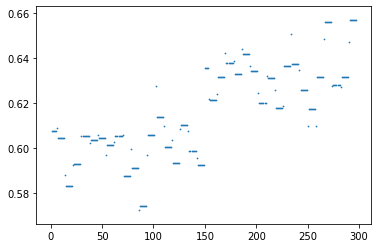

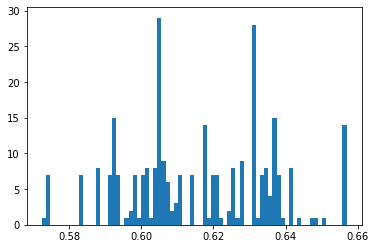

Average value is:  0.61580914
Total Predicted Positive:  147  out of  297
49.494949494949495 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## CNN Model 7
## create the model
modelCNN7 = 0
modelCNN7 = Sequential()
modelCNN7.add(Conv2D(4, kernel_size=(2, 2),activation='relu'))
modelCNN7.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN7.add(Flatten())
modelCNN7.add(Dense(1, activation='sigmoid'))
modelCNN7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelCNN7.build(input_shape) # `input_shape` is the shape of the input data

print(modelCNN7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelCNN7.fit(X_train7, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7, y_val7),verbose=1)

  # Test the model
  y_pred = modelCNN7.predict(X_val7)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

In [0]:
###########################################################################################################################
#------------------------------------------------------------RNN Model-----------------------------------------------#
###########################################################################################################################

In [0]:
# User defined parameters, for RNN particularly
# https://datascience.stackexchange.com/questions/20442/recurrent-neural-network-producing-same-predictions
# Has suggested that increasing batch size will help RNN stop predicting the same value for all
batch_size_user = 150
#epoch_user = 1
#times_to_loop_model = 5

print("User defined parameters set")
print(batch_size_user)
print(epoch_user)
print(times_to_loop_model)

User defined parameters set
150
1
3


In [0]:
print(input_shape)
print(flatten_shape)

(None, 100, 200, 3)
(None, 20000, 3)


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 3s 3s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6903 - val_acc: 1.0000
(298, 1)


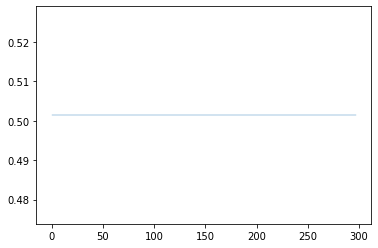

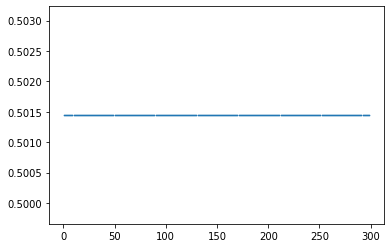

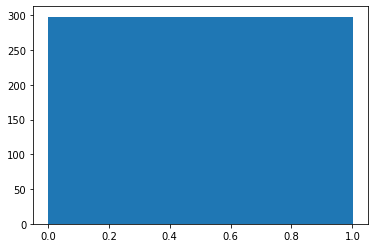

Average value is:  0.501446
Total Predicted Positive:  298  out of  298
100.0 %
Epoch:  2
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.6903 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 1.0000
(298, 1)


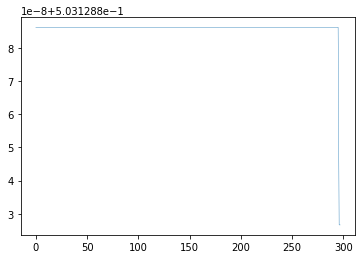

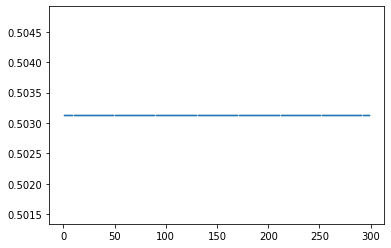

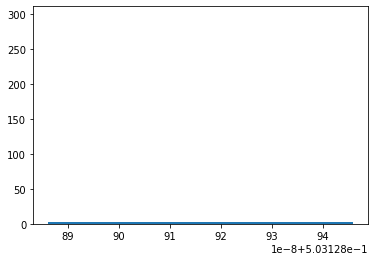

Average value is:  0.50312895
Total Predicted Positive:  0  out of  298
0.0 %
Epoch:  3
Train on 1 samples, validate on 298 samples
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.6869 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 1.0000
(298, 1)


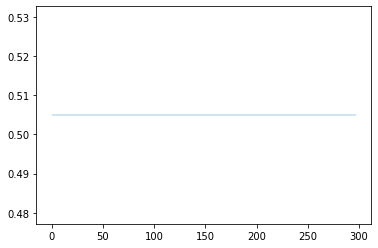

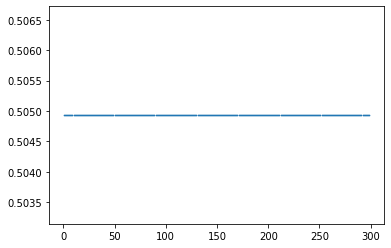

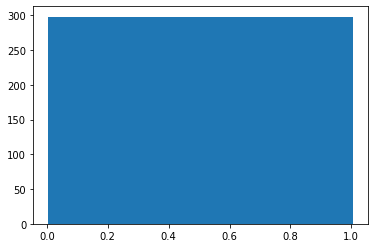

Average value is:  0.504932
Total Predicted Positive:  298  out of  298
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 1
## create the model
modelRNNLSTM1 = 0
modelRNNLSTM1 = Sequential()
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM1.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM1.add(Dense(1, activation='sigmoid'))
modelRNNLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM1.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM1.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM1.fit(X_train1_flatten, y_train1, epochs=1, batch_size=batch_size_user, validation_data = (X_val1_flatten, y_val1),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM1.predict(X_val1_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 4s 63ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6903 - val_acc: 1.0000
(239, 1)


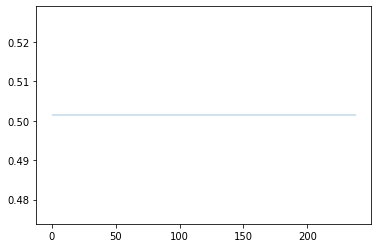

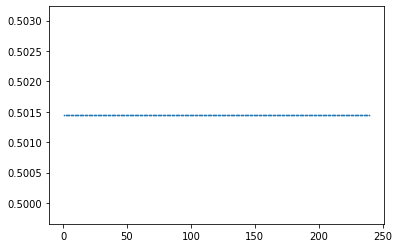

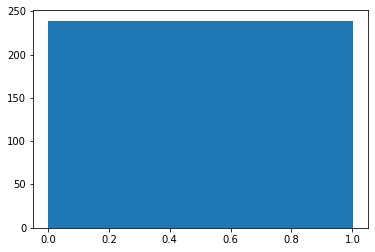

Average value is:  0.5014459
Total Predicted Positive:  239  out of  239
100.0 %
Epoch:  2
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 2s 36ms/step - loss: 0.6903 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 1.0000
(239, 1)


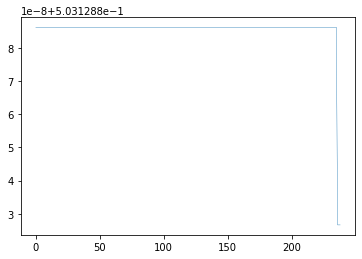

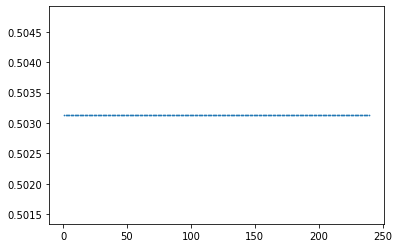

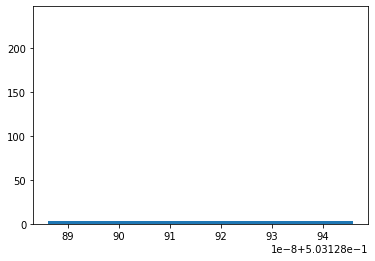

Average value is:  0.50312895
Total Predicted Positive:  0  out of  239
0.0 %
Epoch:  3
Train on 60 samples, validate on 239 samples
Epoch 1/1
60/60 [==============================] - 2s 37ms/step - loss: 0.6869 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 1.0000
(239, 1)


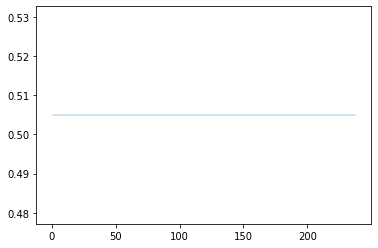

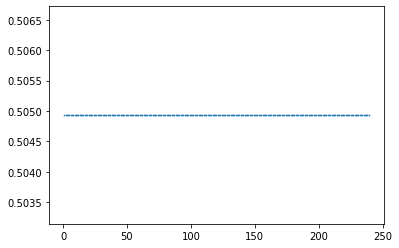

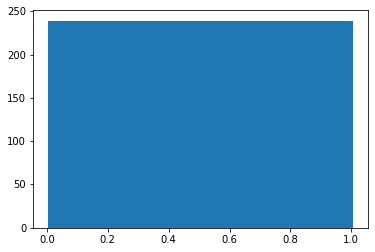

Average value is:  0.504932
Total Predicted Positive:  239  out of  239
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 2
## create the model
modelRNNLSTM2 = 0
modelRNNLSTM2 = Sequential()
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM2.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM2.add(Dense(1, activation='sigmoid'))
modelRNNLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM2.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM2.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM2.fit(X_train2_flatten, y_train2, epochs=1, batch_size=batch_size_user, validation_data = (X_val2_flatten, y_val2),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM2.predict(X_val2_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 4s 34ms/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 1.0000
(179, 1)


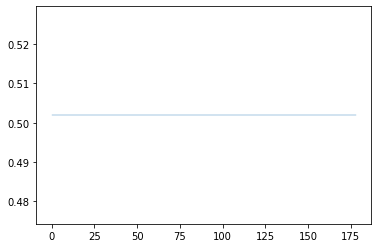

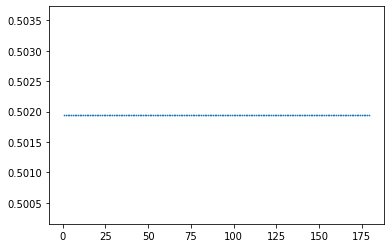

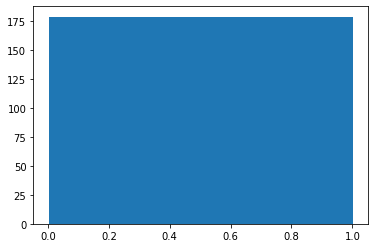

Average value is:  0.50194305
Total Predicted Positive:  0  out of  179
0.0 %
Epoch:  2
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 2s 19ms/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
(179, 1)


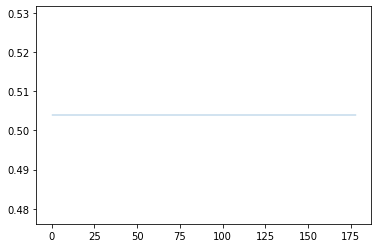

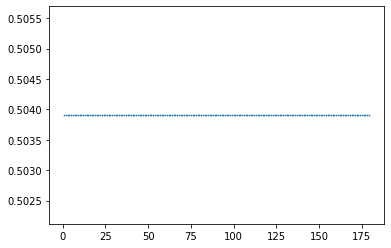

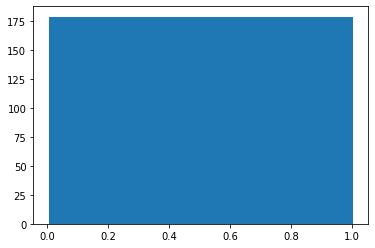

Average value is:  0.50390714
Total Predicted Positive:  179  out of  179
100.0 %
Epoch:  3
Train on 120 samples, validate on 179 samples
Epoch 1/1
120/120 [==============================] - 2s 19ms/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.6814 - val_acc: 1.0000
(179, 1)


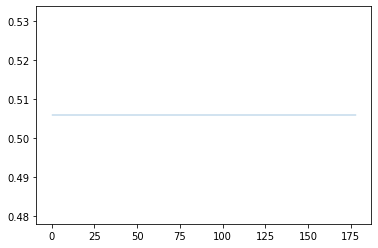

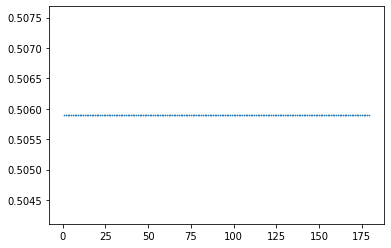

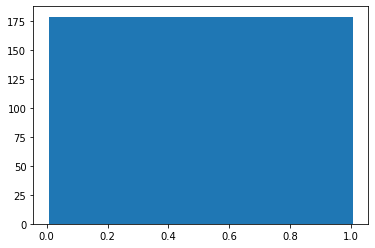

Average value is:  0.50589645
Total Predicted Positive:  0  out of  179
0.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 3
## create the model
modelRNNLSTM3 = 0
modelRNNLSTM3 = Sequential()
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM3.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM3.add(Dense(1, activation='sigmoid'))
modelRNNLSTM3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM3.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM3.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM3.fit(X_train3_flatten, y_train3, epochs=1, batch_size=batch_size_user, validation_data = (X_val3_flatten, y_val3),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM3.predict(X_val3_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 2)                 48        
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 5s 28ms/step - loss: 0.6925 - acc: 0.1667 - val_loss: 0.6854 - val_acc: 1.0000
(119, 1)


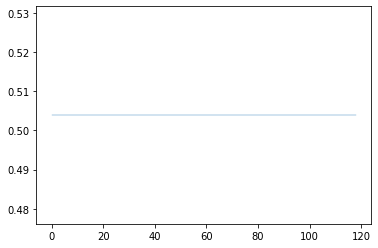

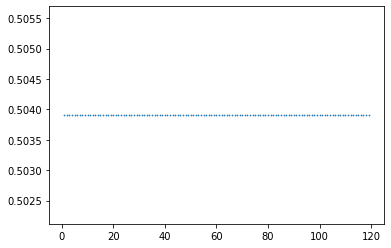

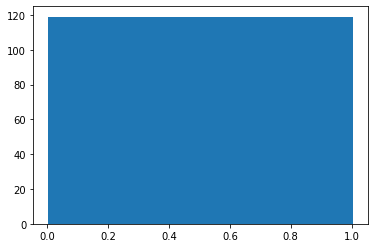

Average value is:  0.50390714
Total Predicted Positive:  119  out of  119
100.0 %
Epoch:  2
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 3s 17ms/step - loss: 0.6847 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 1.0000
(119, 1)


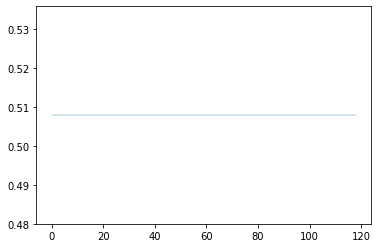

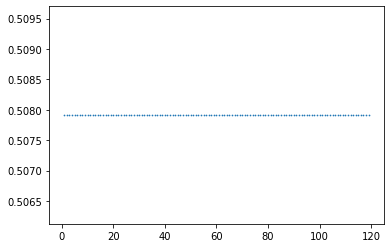

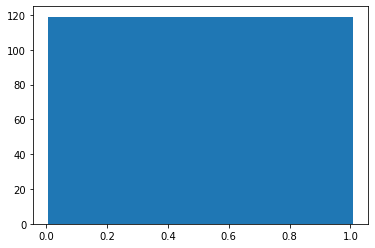

Average value is:  0.50791174
Total Predicted Positive:  119  out of  119
100.0 %
Epoch:  3
Train on 180 samples, validate on 119 samples
Epoch 1/1
180/180 [==============================] - 3s 17ms/step - loss: 0.6768 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 1.0000
(119, 1)


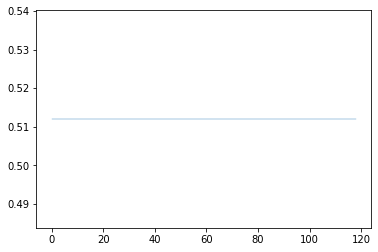

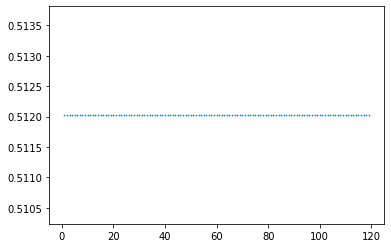

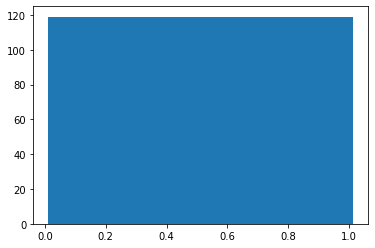

Average value is:  0.512024
Total Predicted Positive:  119  out of  119
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 4
## create the model
modelRNNLSTM4 = 0
modelRNNLSTM4 = Sequential()
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM4.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM4.add(Dense(1, activation='sigmoid'))
modelRNNLSTM4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM4.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM4.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM4.fit(X_train4_flatten, y_train4, epochs=1, batch_size=batch_size_user, validation_data = (X_val4_flatten, y_val4),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM4.predict(X_val4_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 5s 21ms/step - loss: 0.6917 - acc: 0.3750 - val_loss: 0.6854 - val_acc: 1.0000
(59, 1)


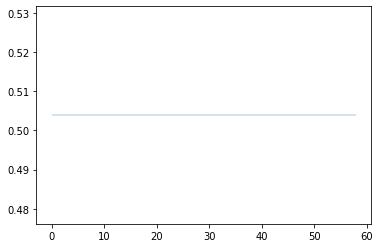

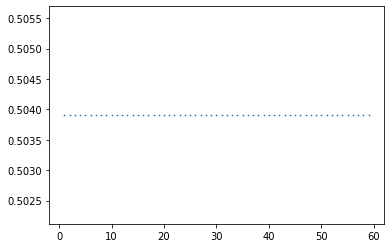

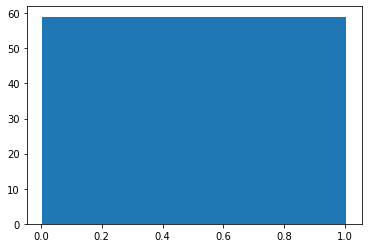

Average value is:  0.50390714
Total Predicted Positive:  59  out of  59
100.0 %
Epoch:  2
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 3s 12ms/step - loss: 0.6839 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 1.0000
(59, 1)


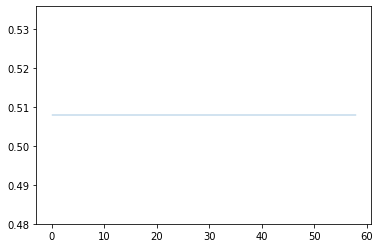

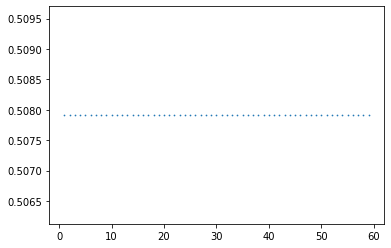

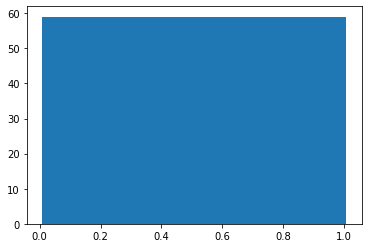

Average value is:  0.50791174
Total Predicted Positive:  59  out of  59
100.0 %
Epoch:  3
Train on 240 samples, validate on 59 samples
Epoch 1/1
240/240 [==============================] - 3s 12ms/step - loss: 0.6759 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 1.0000
(59, 1)


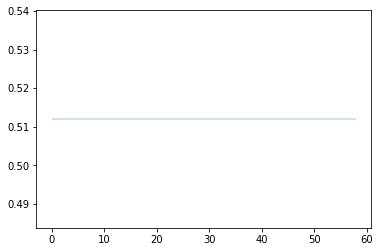

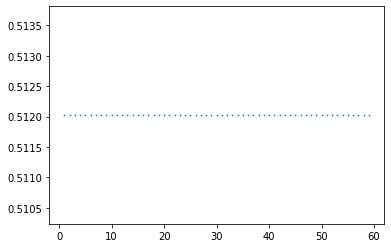

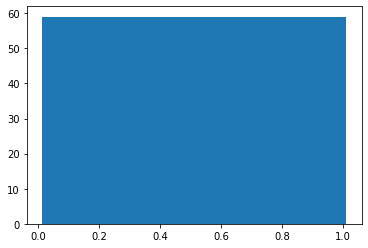

Average value is:  0.512024
Total Predicted Positive:  59  out of  59
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 5
## create the model
modelRNNLSTM5 = 0
modelRNNLSTM5 = Sequential()
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM5.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM5.add(Dense(1, activation='sigmoid'))
modelRNNLSTM5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM5.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM5.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM5.fit(X_train5_flatten, y_train5, epochs=1, batch_size=batch_size_user, validation_data = (X_val5_flatten, y_val5),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM5.predict(X_val5_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_11 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_12 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 5s 18ms/step - loss: 0.6913 - acc: 0.4828 - val_loss: 0.6854 - val_acc: 1.0000
(9, 1)


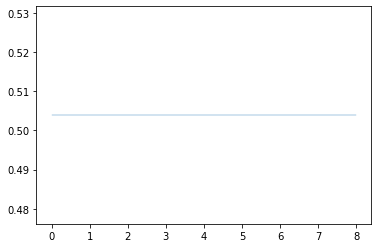

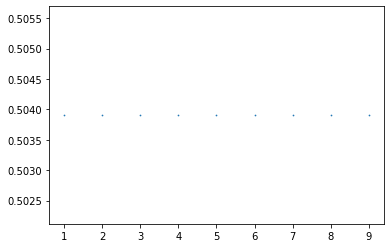

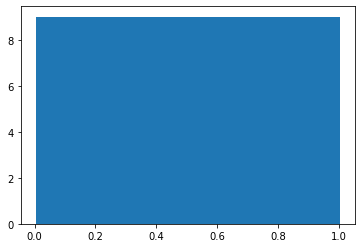

Average value is:  0.50390714
Total Predicted Positive:  9  out of  9
100.0 %
Epoch:  2
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 3s 11ms/step - loss: 0.6835 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 1.0000
(9, 1)


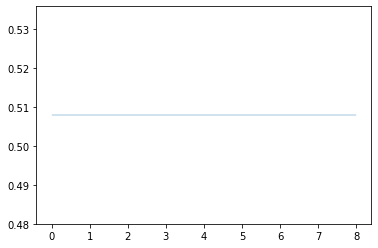

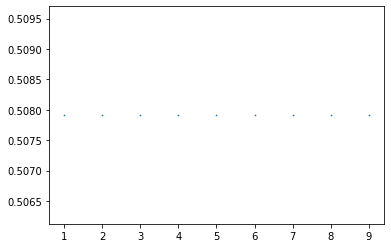

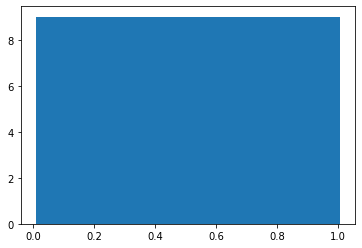

Average value is:  0.5079118
Total Predicted Positive:  9  out of  9
100.0 %
Epoch:  3
Train on 290 samples, validate on 9 samples
Epoch 1/1
290/290 [==============================] - 3s 11ms/step - loss: 0.6755 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 1.0000
(9, 1)


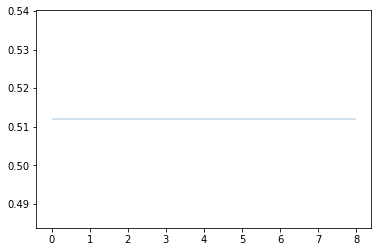

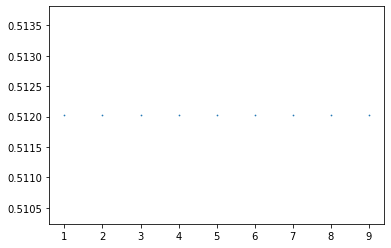

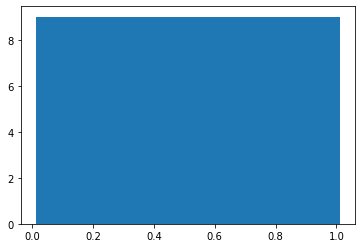

Average value is:  0.512024
Total Predicted Positive:  9  out of  9
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 6
## create the model
modelRNNLSTM6 = 0
modelRNNLSTM6 = Sequential()
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM6.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM6.add(Dense(1, activation='sigmoid'))
modelRNNLSTM6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM6.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM6.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM6.fit(X_train6_flatten, y_train6, epochs=1, batch_size=batch_size_user, validation_data = (X_val6_flatten, y_val6),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM6.predict(X_val6_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 20000, 2)          56        
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 2)                 48        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 3         
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
None
Epoch:  1
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 4s 2s/step - loss: 0.6931 - acc: 0.0000e+00 - val_loss: 0.6893 - val_acc: 1.0000
(297, 1)


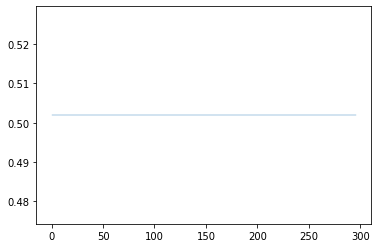

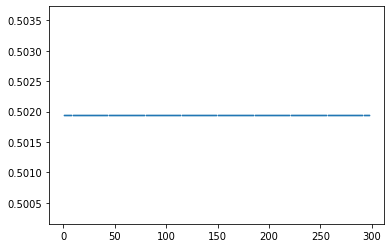

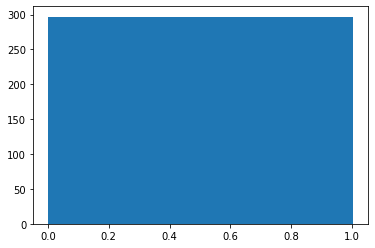

Average value is:  0.50194305
Total Predicted Positive:  0  out of  297
0.0 %
Epoch:  2
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 2s 1s/step - loss: 0.6893 - acc: 1.0000 - val_loss: 0.6854 - val_acc: 1.0000
(297, 1)


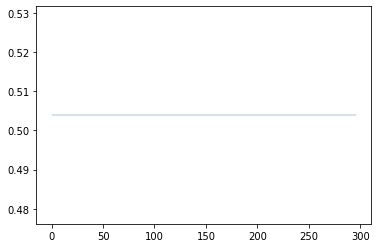

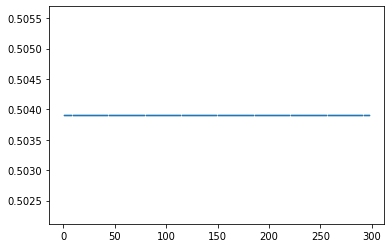

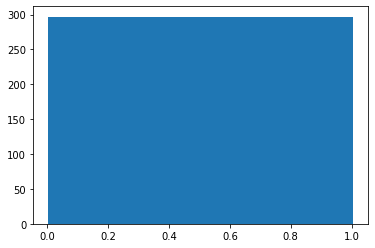

Average value is:  0.5039072
Total Predicted Positive:  0  out of  297
0.0 %
Epoch:  3
Train on 2 samples, validate on 297 samples
Epoch 1/1
2/2 [==============================] - 2s 1s/step - loss: 0.6854 - acc: 1.0000 - val_loss: 0.6814 - val_acc: 1.0000
(297, 1)


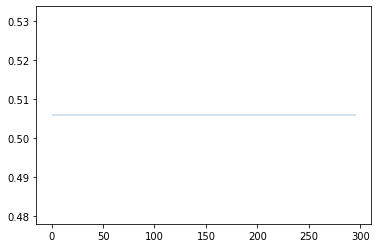

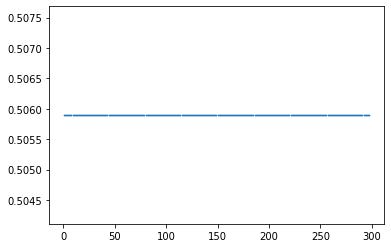

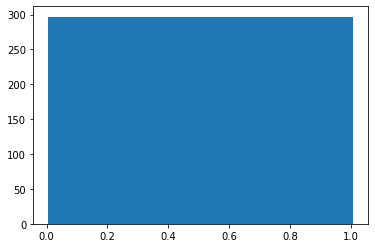

Average value is:  0.5058964
Total Predicted Positive:  297  out of  297
100.0 %


In [0]:
# To ensure results can be repeated, the same seed value should be used for all testing
seed_value = 2020
seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_random_seed(seed_value)

########################################################################################################################################################################
## RNN Model 7
## create the model
modelRNNLSTM7 = 0
modelRNNLSTM7 = Sequential()
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2, input_shape=(flatten_value,3),return_sequences=True))
modelRNNLSTM7.add(cudnn_recurrent.CuDNNLSTM(units=2))
modelRNNLSTM7.add(Dense(1, activation='sigmoid'))
modelRNNLSTM7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# build for different input shape
modelRNNLSTM7.build(flatten_shape) # `input_shape` is the shape of the input data

print(modelRNNLSTM7.summary())

epochCounter = 1
for counter in range(0,times_to_loop_model):
  print("Epoch: ", epochCounter)
  # Fit the model
  modelRNNLSTM7.fit(X_train7_flatten, y_train7, epochs=1, batch_size=batch_size_user, validation_data = (X_val7_flatten, y_val7),verbose=1)

  # Test the model
  y_pred = modelRNNLSTM7.predict(X_val7_flatten)

  # Print out the results
  print(y_pred.shape)

  plt.plot(y_pred, lw=0.4)
  plt.show()
  plt.scatter(range(1,len(y_pred)+1),y_pred[:,0],s=0.5)
  plt.show()
  plt.hist(y_pred,bins=len(np.unique(y_pred)))
  plt.show()

  avg = np.average(y_pred)
  print("Average value is: ", avg)

  y_pred_thres = y_pred

  y_pred_thres[y_pred_thres<avg] = 0
  y_pred_thres[y_pred_thres>=avg] = 1

  totalsum = 0
  for i in range(y_pred_thres.size):
    if(y_pred_thres[i] == 1):
      totalsum += 1

  print("Total Predicted Positive: ", totalsum, " out of ", len(y_pred_thres))
  print(totalsum / y_pred_thres.size * 100, "%")
  epochCounter += 1